In [3]:
# ##installs pytorch on a cuda-capable windows machine using pip

# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# %pip install torchsummary

# %pip install numpy

# %pip install matplotlib

# %pip install opencv-python

# %pip install scikit-learn

# %pip install pandas

# %pip install tqdm

# %pip install pickle5

In [1]:
import torch
import torch.nn as nn
import os
import cv2
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
from torchvision import models
from torchvision import transforms
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier


In [3]:
if(os.path.split(os.getcwd())[1] == "Transfer_Learning"):
    os.chdir("..")
print("Current Working Directory: {}".format(os.path.split(os.getcwd())[1]))

cuda = torch.cuda.is_available()
print(cuda)

Current Working Directory: progettoVIPM
True


In [4]:
from utils.loadersAndEnums import datasets
from utils.loadersAndEnums import networks
from utils.loadersAndEnums import ImageDataset
from utils.extractNeuralFeatures import extract_features

In [5]:
chosen_net = networks.ALEXNET
print("Original classification layers:{}".format(chosen_net.value[1]))
print(chosen_net.value[1].features)

Original classification layers:AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, 

In [6]:
from torchvision.transforms import v2 
 
t = v2.RandomApply([ 
    v2.RandomHorizontalFlip(1), 
    v2.RandomVerticalFlip(1), 
    v2.RandomRotation(30), 
    v2.RandomAffine(0, translate=(0.1,0.1)), 
    v2.RandomResizedCrop(256,scale=(0.8,1.0)), 
    v2.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0), 
    v2.GaussianBlur(3, sigma=(0.1, 2.0)), 
    v2.GaussianNoise(0.01), 
    v2.RandomEqualize() 
])

In [6]:
# t sta per "tensor", ovvero il vettore sulla gpu, mentre "n" sta per "numpy", ovvero il vettore sulla cpu

linear_layers_to_remove = 2
X_train_ale_t, X_train_ale_n, y_train, X_test_ale_t, X_test_ale_n, y_test, fine_tune_layers, modified_net = extract_features(train_set=datasets.TRAINING_80,
                                                                                            test_set=datasets.VALIDATION_20,
                                                                                            network=chosen_net,
                                                                                            layers_to_remove=linear_layers_to_remove, 
                                                                                            cuda=cuda, middle=False)
print("Original classification layers:{}".format(chosen_net.value[1].classifier[:]))
print("---------------------------------------------------------------------------------")
print("Classification layers to fine tune:{}".format(fine_tune_layers[:]))

Found an existing set of features in: ./Storage/neural_features/Train_AlexNet_minus2_training_set_80%.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Train: 4016
Feature vector shape of Train: (4016, 4096)
Label vector shape of Train: (4016,)
---------------------------------------------------------------------------------
Found an existing set of features in: ./Storage/neural_features/Test_AlexNet_minus2_train_set.npy
Loading features from file:
---------------------------------------------------------------------------------
Done feat extraction, total n° of istances in Test: 1004
Feature vector shape of Test: (1004, 4096)
Label vector shape of Test: (1004,)
---------------------------------------------------------------------------------
Original classification layers:Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=T

In [24]:
import pickle
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def model_building(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()
    plt.savefig("./Transfer_Learning/model_metrics/ConfM_{}.pdf".format(model_name))
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    with open('./Storage/models/{}.pkl'.format(model_name),'wb') as f:
        pickle.dump(model,f)
    return acc

In [80]:
array = []
for i in range(0,len(X_train_ale_n)):
    array.append(np.matrix.flatten(X_train_ale_n[i]))
array = np.array(array)
print(array.shape)
X_train_ale_n= array

array = []
for i in range(0,len(X_test_ale_n)):
    array.append(np.matrix.flatten(X_test_ale_n[i]))
array = np.array(array)
print(array.shape)
X_test_ale_n = array


MemoryError: Unable to allocate 6.01 GiB for an array with shape (4016, 200704) and data type float64

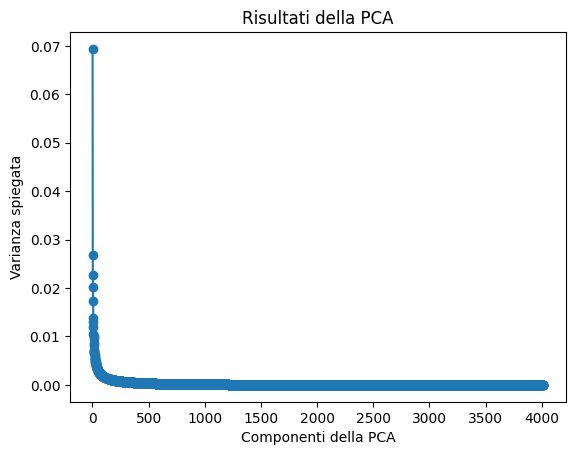

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

is_pca_used = True

scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train_ale_n)
pca = PCA().fit(scaled_data)

plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Componenti della PCA')
plt.ylabel('Varianza spiegata')
plt.title("Risultati della PCA")
plt.show()


In [ ]:
components = 500
pca = PCA(n_components=components).fit(scaled_data)
X_train_pca = pca.transform(scaled_data)
print("Final input shape train: {}".format(X_train_pca.shape))

scaled_data = scaler.fit_transform(X_test_ale_n)
x_test_pca = pca.transform(scaled_data)
print("Final input shape test: {}".format(x_test_pca.shape))

Final input shape train: (4016, 500)
Final input shape test: (1004, 500)


 14%|█▍        | 1/7 [31:41<3:10:06, 1901.16s/it]

Linear Support Vector obtained following accuracy: 0.013944223107569721


 29%|██▊       | 2/7 [32:50<1:08:38, 823.76s/it] 

Rbf Support Vector obtained following accuracy: 0.046812749003984064


 43%|████▎     | 3/7 [33:32<31:07, 466.79s/it]  

KNN with 1 neighbors obtained following accuracy: 0.0199203187250996


 57%|█████▋    | 4/7 [34:14<14:56, 298.84s/it]

KNN with 10 neighbors obtained following accuracy: 0.01593625498007968


 71%|███████▏  | 5/7 [34:55<06:52, 206.10s/it]

KNN with 20 neighbors obtained following accuracy: 0.01693227091633466


 86%|████████▌ | 6/7 [35:37<02:30, 150.33s/it]

KNN with 50 neighbors obtained following accuracy: 0.0249003984063745


100%|██████████| 7/7 [36:18<00:00, 311.17s/it]

Naive Bayes obtained following accuracy: 0.021912350597609563


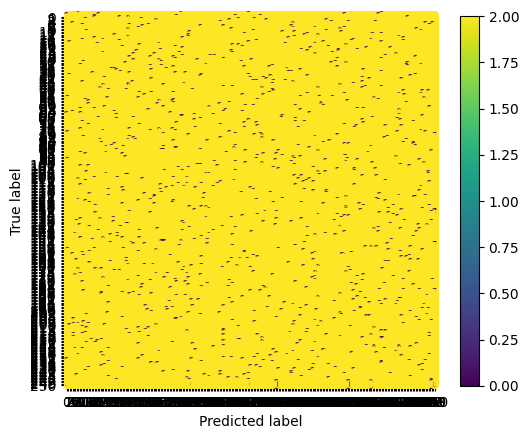

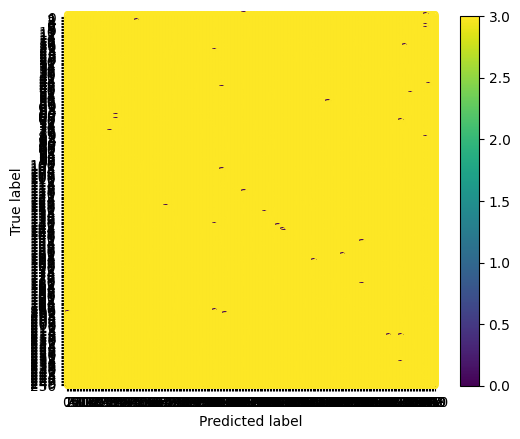

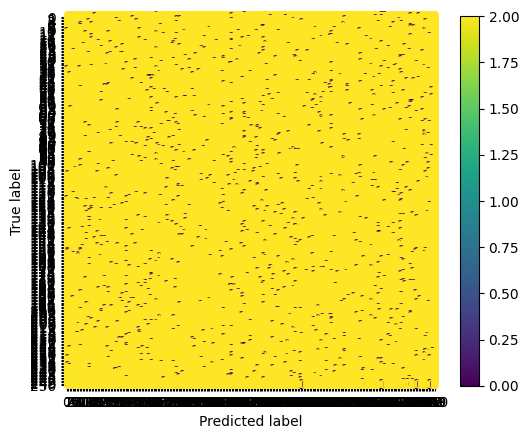

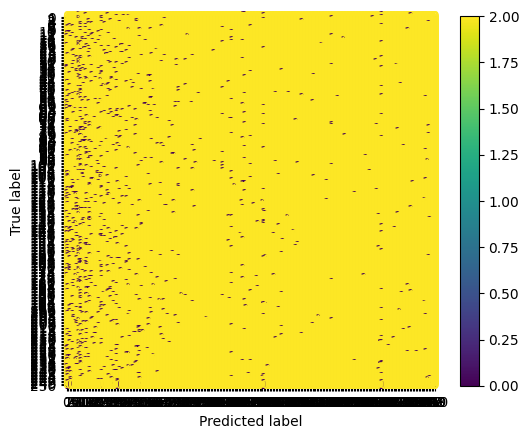

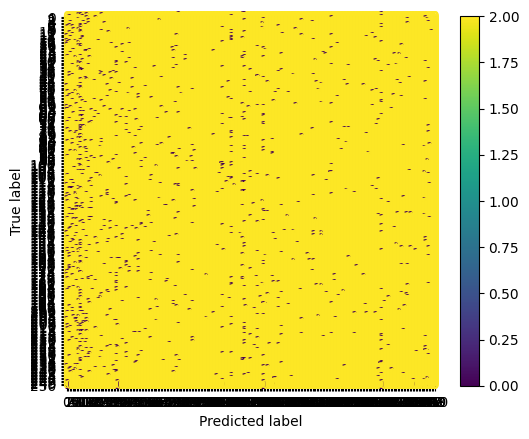

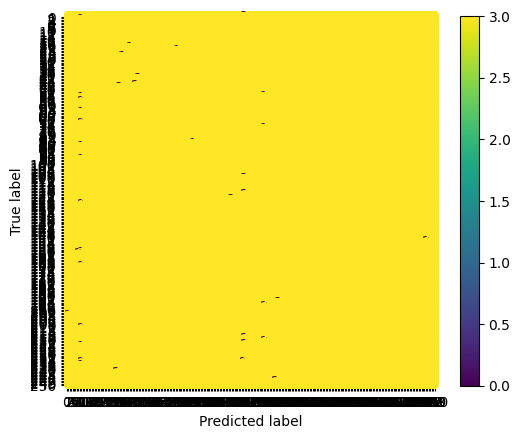

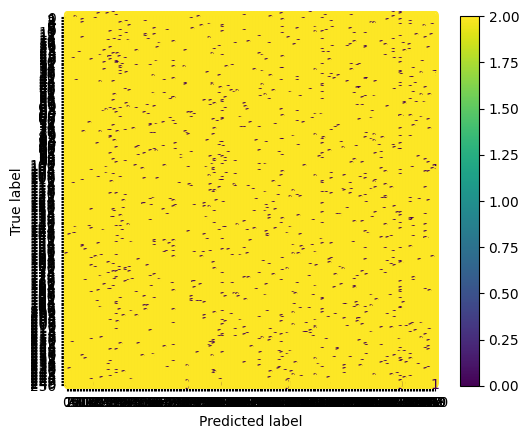

In [ ]:

from enum import Enum
class ml_models(Enum):
    LINEAR_SVC = [LinearSVC(), "Linear Support Vector"]
    RBF_SVC = [SVC(kernel="rbf"), "Rbf Support Vector"]
    # RANDOM_FOREST = [RandomForestClassifier(), "Random Forest"]
    # BOOSTED_FOREST = [GradientBoostingClassifier(), "Gradient Boosting Classifier"]
    KNN_1 = [KNeighborsClassifier(n_neighbors=1), "KNN with 1 neighbors"]
    KNN_10 = [KNeighborsClassifier(n_neighbors=10), "KNN with 10 neighbors"]
    KNN_20 = [KNeighborsClassifier(n_neighbors=20), "KNN with 20 neighbors"]
    KNN_50 = [KNeighborsClassifier(n_neighbors=50), "KNN with 50 neighbors"]
    NAIVE_BAYES = [GaussianNB(), "Naive Bayes"]

is_pca_used = True
extra = [False, "_mixed_dataset"]

x_train = X_train_ale_n
x_test = X_test_ale_n
if is_pca_used:
    x_train = X_train_pca
    x_test =x_test_pca
model_accuracies = []
for model in tqdm(ml_models):    
    model_name = "{}_from_{}_until{}".format(model.value[1], chosen_net.value[2], linear_layers_to_remove)
    if is_pca_used:
        model_name += "_pca"
    if extra[0]:
        model_name += extra[1]
    score = model_building(model.value[0], model_name, x_train, x_test, y_train, y_test)
    print("{} obtained following accuracy: {}".format(model.value[1],score))
    model_accuracies.append([model_name, score])
model_accuracies = np.array(model_accuracies)
accuracies_filename = "./Transfer_Learning/model_metrics/Accuracies_{}_until{}".format(chosen_net.value[2], linear_layers_to_remove)
if is_pca_used:
    accuracies_filename += "_pca"
if extra[0]:
        model_name += extra[1]

np.save("{}.npy".format(accuracies_filename), model_accuracies)

In [7]:
from utils.fine_tune_pytorch import fine_tune_network_layers, eval_model_on_test_set, train_model
from copy import deepcopy
from utils.loadersAndEnums import dataloader_stratified_kfold
from utils.extractNeuralFeatures import extract_features_from_dataloader
from IPython.display import clear_output

In [9]:
for param in fine_tune_layers.parameters():
    print(param.requires_grad)
    
loss_function = torch.nn.CrossEntropyLoss()

model = deepcopy(fine_tune_layers)

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

n_epochs = 60
batch_size = 64
k_for_accuracy = 5

stratified_kFold = False

if stratified_kFold:
    dataloaders = dataloader_stratified_kfold(dataset=datasets.TRAINING_80, k=5, network_input_size=227, batch_size=1, shuffle=False, cuda=True, transform=None, y_cuda=None)
    trained_models = []
    models_losses = []
    models_accuracies = []
    models_k_accuracies = []
    i = 0
    for train_val_loader in dataloaders:
        clear_output()
        print("-------------------Training on {} fold-------------------".format(i+1))
        train_loader = train_val_loader[0]
        val_loader = train_val_loader[1]
        x_train, y_train = extract_features_from_dataloader(loader=train_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        x_val, y_val = extract_features_from_dataloader(loader=val_loader, out_features = 4096,transfer_network=modified_net, dataset_type="labelled")
        
        fold_net = deepcopy(model)

        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        
        trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda=cuda, model=fold_net, x_train =x_train.cuda(), y_train=y_train, n_epochs=n_epochs, x_val=x_val, y_val = y_val,
                                                                                 batch_size=batch_size,loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)
        # trained_models[i] = trained_model
        # models_losses[i] = losses
        # models_accuracies[i] = accuracies
        # models_k_accuracies[i] = k_accuracies
        trained_models.append(trained_model)
        models_losses.append(losses)
        models_accuracies.append(accuracies)
        models_k_accuracies.append(k_accuracies)
        i += 1
        print("---------------------------------------------------------")
else:
    trained_model, losses, accuracies, k_accuracies = fine_tune_network_layers(cuda, model=model, x_train=X_train_ale_t.cuda(), y_train=y_train, n_epochs=n_epochs,
                                                 batch_size=batch_size, loss_function=loss_function, optimizer=optimizer, k_for_accuracy= k_for_accuracy)


True
True
True
True
------------------Layers to fine-tune------------------
Sequential(
  (0): Linear(in_features=4096, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=4096, out_features=251, bias=True)
)
-------------------------------------------------------
EPOCH 1:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.696002608851383, Accuracy: 0.4426002766251729%, 5-Accuracy: 1.9640387275242046%
--------------------------------------------------
--------------------Validation--------------------
Validation Loss: 5.664290087563651, Accuracy: 0.0%, 5-Accuracy: 1.9950124688279303%
EPOCH 2:
---------------------Training---------------------
Batch 10 di 57
Batch 20 di 57
Batch 30 di 57
Batch 40 di 57
Batch 50 di 57
Training Loss: 5.555347886001854, Accuracy: 0.7745504840940526%, 5-Accuracy: 3.1535269709543567%
--------------------------------------------------
----

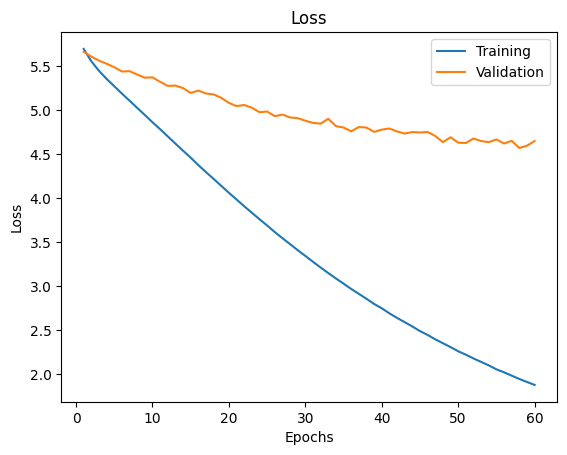

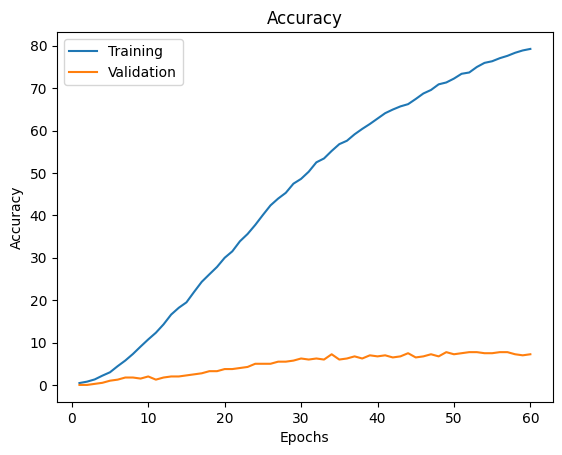

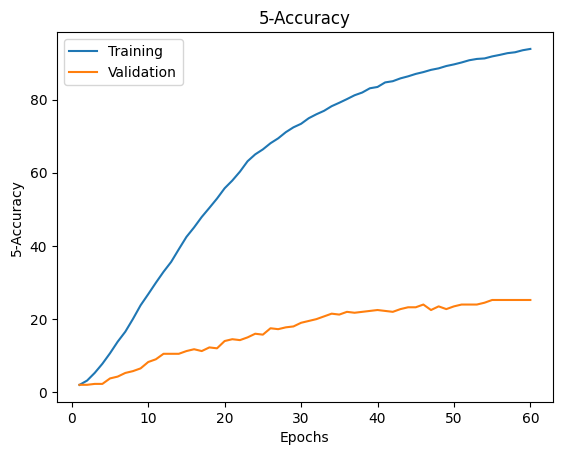

In [10]:

def plot(history, type, model_name):
  x_plot = list(range(1,len(history)+1))
  plt.figure()
  plt.title(type)
  plt.xlabel('Epochs')
  plt.ylabel(type)
  plt.plot(x_plot, history[:,0])
  plt.plot(x_plot, history[:,1])
  plt.legend(['Training', 'Validation'])
  plt.savefig("./Transfer_Learning/models_plots/Alexnet/{}_{}.png".format(type,model_name))

extra = [False, "_mixed_dataset"]

if stratified_kFold:
  for i in range(5):
    model_name = "minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    if extra[0]:
          model_name += extra[1]
    plot(models_losses[i], "Loss", model_name=model_name)
    plot(models_accuracies[i], "Accuracy", model_name=model_name)
    plot(models_k_accuracies[i], f"{k_for_accuracy}-Accuracy", model_name=model_name)
else:
  model_name = "minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  plot(losses, "Loss", model_name=model_name)
  plot(accuracies, "Accuracy", model_name=model_name)
  plot(k_accuracies, f"{k_for_accuracy}-Accuracy", model_name=model_name)

In [11]:
if stratified_kFold:
  for i in range(5):
    print("model of fold: {}".format(i+1))
    model_name = "finetunedAlexNet_minus{}_{}e_{}bsize_80_20_split_fold{}".format(linear_layers_to_remove, n_epochs, batch_size, i+1)
    if extra[0]:
        model_name += extra[1]
    cm = eval_model_on_test_set(trained_models[i], model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
    cm = np.array(cm)
    np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
    torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
else:
  model_name= "finetunedAlexNet_minus{}_{}e_{}bsize_80_20_split".format(linear_layers_to_remove, n_epochs, batch_size)
  if extra[0]:
        model_name += extra[1]
  cm = eval_model_on_test_set(trained_model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)
  np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
  print("CM filename: {}".format("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name)))
  torch.save(trained_model, "./Storage/models/Neural_models/{}.pth".format(model_name))
  print("Model saved at: {}".format("./Storage/models/Neural_models/{}.pth".format(model_name)))

100%|██████████| 1004/1004 [00:02<00:00, 460.75it/s]


Accuracy: 11.653386454183266 %
5-Accuracy: 26.693227091633464
CM filename: ./Transfer_Learning/model_metrics/ConfM_finetunedAlexNet_minus2_60e_64bsize_80_20_split.npy
Model saved at: ./Storage/models/Neural_models/finetunedAlexNet_minus2_60e_64bsize_80_20_split.pth


In [13]:
linear_layers_to_remove

2

In [8]:
n_epochs = 200
batch_size = 128
k_for_accuracy = 10
model = torch.load("./Storage/models/Neural_models/finetunedAlexNet_minus{}_{}e_80_20_split.pth".format(linear_layers_to_remove, n_epochs))

In [11]:
model_name= "Alexnet_minus{}_{}_epoch_mixed_dataset".format(linear_layers_to_remove, n_epochs)
cm = eval_model_on_test_set(model, model_name=model_name, target_dir="Transfer_Learning", x_test=X_test_ale_t.cuda(), y_test=y_test, cuda=cuda, k_for_accuracy = k_for_accuracy)

100%|██████████| 11994/11994 [13:34<00:00, 14.73it/s]

Accuracy: 0.10246790061697515
10-Accuracy: 37.910621977655495


In [18]:
%pip install tensorboardX

Note: you may need to restart the kernel to use updated packages.


In [80]:
def train_one_epoch(epoch_index, tb_writer, training_loader, model, loss_function, optimizer):
    running_loss = 0.
    avg_batch_loss = 0.
    n_batch = 0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_function(outputs, labels)
        avg_batch_loss += loss.item()
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        # running_loss += loss.item()
        # if i % 10 == 9:
        #     last_loss = running_loss / 10 # loss per batch
        #     print('  batch {} loss: {}'.format(i + 1, last_loss))
        #     tb_x = epoch_index * len(training_loader) + i + 1
        #     tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        #     running_loss = 0.
        n_batch += 1

    return avg_batch_loss/n_batch

In [21]:
from datetime import datetime
from tensorboardX import SummaryWriter
from IPython.display import clear_output
def train_model(training_loader, validation_loader, n_epochs, model, loss_function, optimizer):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter('runs/trainer_{}'.format(timestamp))

    epoch_number = 0


    best_vloss = 1_000_000.

    losses = np.empty((n_epochs,2))


    for epoch in range(n_epochs):
        clear_output(wait=True)
        print('EPOCH {}:'.format(epoch_number + 1))

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch_number, writer, training_loader, model, loss_function, optimizer)


        running_vloss = 0.0
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(validation_loader):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = loss_function(voutputs, vlabels)
                running_vloss += vloss.item()

        avg_vloss = running_vloss / (i + 1)
        losses[epoch_number] = [avg_loss, avg_vloss]
        print('LOSS: train {}; valid {}'.format(avg_loss, avg_vloss))

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch_number + 1)
        writer.flush()

        # Track best performance, and save the model's state
        # if avg_vloss < best_vloss:
        #     best_vloss = avg_vloss
        #     model_path = './Transfer_Learning/models/neural/model_{}_{}'.format(timestamp, epoch_number)
        #     torch.save(model.state_dict(), model_path)

        epoch_number += 1
    return model, losses

In [84]:
trained_model.eval()

predictions = np.zeros(len(test_loader))
# Disable gradient computation and reduce memory consumption.
with torch.no_grad():
    i = 0
    for test_data in tqdm(test_loader):
        test_features, test_labels = test_data
        predictions[i] = np.argmax(np.array(trained_model(test_features).cpu()))
        i+=1
y_test = np.array(y_test.cpu())
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {}".format(accuracy))
cm = confusion_matrix(y_test, predictions)
cm = np.array(cm)
model_name="Alexnet"
np.save("./Transfer_Learning/model_metrics/ConfM_{}.npy".format(model_name), cm)
        

100%|██████████| 11994/11994 [00:07<00:00, 1618.24it/s]

Accuracy: 0.1424045356011339
